In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Replace 0 with your GPU ID

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
import gymnax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from wrappers import (
    GymnaxWrapper,
    LogWrapper,
    BraxGymnaxWrapper,
    VecEnv,
    NormalizeVecObservation,
    NormalizeVecReward,
    ClipAction,
)


class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param("log_std", nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            256, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray


def make_train(config):
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ENVS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )
    #env, env_params = BraxGymnaxWrapper(config["ENV_NAME"]), None
    env, env_params = gymnax.make(config["ENV_NAME"])
    env = LogWrapper(env)
    env = ClipAction(env)
    env = VecEnv(env)
    if config["NORMALIZE_ENV"]:
        env = NormalizeVecObservation(env)
        env = NormalizeVecReward(env, config["GAMMA"])

    def linear_schedule(count):
        frac = (
            1.0
            - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"]))
            / config["NUM_UPDATES"]
        )
        return config["LR"] * frac

    def train(rng):
        # INIT NETWORK
        network = ActorCritic(
            env.action_space(env_params).shape[0], activation=config["ACTIVATION"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = env.reset(reset_rng, env_params)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)
                pi, value = network.apply(train_state.params, last_obs)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])
                obsv, env_state, reward, done, info = env.step(
                    rng_step, env_state, action, env_params
                )
                transition = Transition(
                    done, action, value, reward, log_prob, last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            _, last_val = network.apply(train_state.params, last_obs)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ENVS"]
                ), "batch size must be equal to number of steps * number of envs"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]
            if config.get("DEBUG"):

                def callback(info):
                    return_values = info["returned_episode_returns"][
                        info["returned_episode"]
                    ]
                    timesteps = (
                        info["timestep"][info["returned_episode"]] * config["NUM_ENVS"]
                    )
                    for t in range(len(timesteps)):
                        pass
                        '''
                        print(
                            f"global step={timesteps[t]}, episodic return={return_values[t]}"
                        )
                        '''

                jax.debug.callback(callback, metric)

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train




In [3]:
print(jax.devices())

[cuda(id=0)]


In [4]:
config = {
    "LR": 3e-4,
    "NUM_ENVS": 4096 * 64,#2048,
    "NUM_STEPS": 10,
    "TOTAL_TIMESTEPS": 409600 * 800,#5e7,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 32,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu",#"tanh",
    "ENV_NAME": "TwoStageOTA-custom",
    "ANNEAL_LR": False,
    "NORMALIZE_ENV": True,
    "DEBUG": True,
}
print(jax.devices())

rng = jax.random.PRNGKey(30)
train_jit = jax.jit(make_train(config))
#out = train_jit(rng)


[cuda(id=0)]


time: 137.98 s


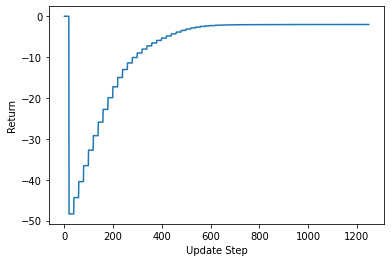

<Figure size 432x288 with 0 Axes>

In [5]:
import time
import matplotlib.pyplot as plt
rng = jax.random.PRNGKey(42)
t0 = time.time()
out = jax.block_until_ready(train_jit(rng))
print(f"time: {time.time() - t0:.2f} s")
plt.plot(out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()
plt.savefig('foo.png')

In [6]:
out_runner_state = (out['runner_state']) # train_state, env_state, last_obs, rng
out_runner_env = ((out['runner_state'][1]))

In [7]:
print(out_runner_env.env_state.env_state.env_state)

EnvState(x0=Array([-0.80772984, -1.        , -0.8155798 , ..., -1.        ,
       -1.        , -0.7220823 ], dtype=float32), x1=Array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32), x2=Array([0.446707  , 0.17568839, 0.7148404 , ..., 0.55311024, 0.44859123,
       0.38524202], dtype=float32), x3=Array([0.12548548, 0.23495317, 0.7042673 , ..., 1.        , 0.74276775,
       1.        ], dtype=float32), x4=Array([0.264692  , 0.38120788, 0.6196549 , ..., 0.3259938 , 0.57321906,
       0.30869418], dtype=float32), x5=Array([-1., -1., -1., ..., -1., -1., -1.], dtype=float32), x6=Array([0.5566417 , 0.9691196 , 0.7699829 , ..., 1.        , 0.18876976,
       1.        ], dtype=float32), x7=Array([1.        , 0.680218  , 0.68729246, ..., 1.        , 0.66386855,
       1.        ], dtype=float32), x8=Array([ 0.3179239 ,  0.5606795 ,  0.21825066, ..., -0.12427047,
        0.16509095,  0.07916529], dtype=float32), x9=Array([ 0.06191698,  1.        ,  0.36778733, ...,  0.6651311 ,
        0.3

Reward top 1 percent cutoff:  -0.05048006664961571


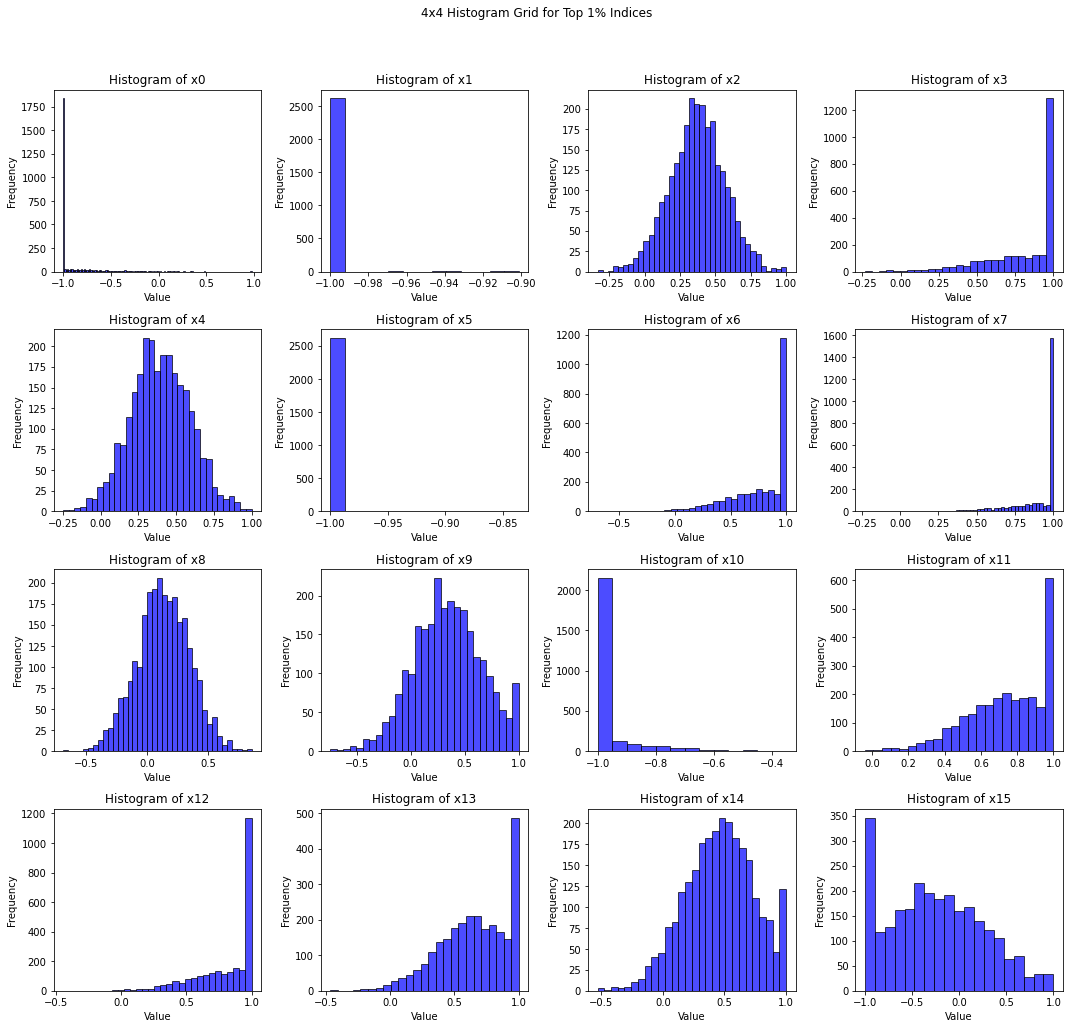

In [8]:
#a = out_runner_env.env_state.env_state.env_state.x11
#plt.hist(a)
# Assuming out_runner_env.env_state.env_state is your object with attributes
A = out_runner_env.env_state.env_state.returned_episode_returns  # Array A

# 1. Determine the threshold for the top 1 percent in array A
percentile_99 = np.percentile(A, 99)
print('Reward top 1 percent cutoff: ', percentile_99)

# 2. Find the indices of values in array A that are above this threshold
top_1_percent_indices = np.where(A >= percentile_99)[0]

# Create a 4x4 grid of histograms
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
fig.suptitle('4x4 Histogram Grid for Top 1% Indices')

for i in range(16):
    # 3. Use these indices to extract values from each of the B arrays
    attr_name = f"x{i}"
    B = getattr(out_runner_env.env_state.env_state.env_state, attr_name)
    extracted_values_from_B = B[top_1_percent_indices]
    
    # Determine the position of the current subplot
    row, col = divmod(i, 4)
    
    # Plot the histogram
    axes[row, col].hist(extracted_values_from_B, bins='auto', alpha=0.7, color='blue', edgecolor='black')
    axes[row, col].set_title(f'Histogram of {attr_name}')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [9]:
print(out_runner_env.env_state.env_state.env_state.x0)

[-0.80772984 -1.         -0.8155798  ... -1.         -1.
 -0.7220823 ]


In [10]:
out_runner_env.env_state

NormalizeVecObsEnvState(mean=Array([[-0.6059499 , -0.7170467 ,  0.11329106, ...,  0.3739178 ,
         0.31049672, -0.04804913],
       [-0.6059499 , -0.7170467 ,  0.11329106, ...,  0.3739178 ,
         0.31049672, -0.04804913],
       [-0.6059499 , -0.7170467 ,  0.11329106, ...,  0.3739178 ,
         0.31049672, -0.04804913],
       ...,
       [-0.6059499 , -0.7170467 ,  0.11329106, ...,  0.3739178 ,
         0.31049672, -0.04804913],
       [-0.6059499 , -0.7170467 ,  0.11329106, ...,  0.3739178 ,
         0.31049672, -0.04804913],
       [-0.6059499 , -0.7170467 ,  0.11329106, ...,  0.3739178 ,
         0.31049672, -0.04804913]], dtype=float32), var=Array([[0.294853  , 0.28361678, 0.26321933, ..., 0.28539574, 0.22713226,
        0.40486786],
       [0.294853  , 0.28361678, 0.26321933, ..., 0.28539574, 0.22713226,
        0.40486786],
       [0.294853  , 0.28361678, 0.26321933, ..., 0.28539574, 0.22713226,
        0.40486786],
       ...,
       [0.294853  , 0.28361678, 0.26321933, 

In [11]:
out_runner_env.env_state.env_state.returned_episode_returns

Array([-2.0464842, -2.2422132, -2.0486367, ..., -2.3286235, -2.258132 ,
       -2.67865  ], dtype=float32)

(array([3.5000e+01, 1.2700e+02, 3.1700e+02, 4.5100e+02, 8.1770e+03,
        3.6434e+04, 7.0812e+04, 8.6111e+04, 4.5148e+04, 1.4532e+04]),
 array([-6.7716012 , -6.09885979, -5.42611837, -4.75337648, -4.08063507,
        -3.40789366, -2.73515224, -2.06241059, -1.38966918, -0.71692765,
        -0.04418612]),
 <BarContainer object of 10 artists>)

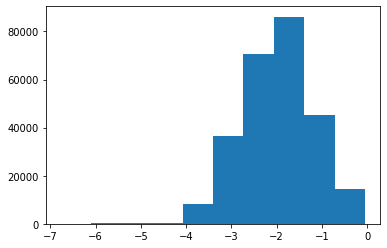

In [12]:
plt.hist(out_runner_env.env_state.env_state.returned_episode_returns)

In [13]:
np.max(out_runner_env.env_state.env_state.returned_episode_returns)

Array(-0.04418612, dtype=float32)

In [14]:
best_index = np.argmax(out_runner_env.env_state.env_state.returned_episode_returns)

In [15]:
# Iterate through the attribute names 'x0' to 'x15'
best_sample_gate_config = []
for i in range(16):
    # Construct the attribute name
    attr_name = f"x{i}"
    
    # Use getattr to fetch the attribute from the env_state.env_state object
    value = getattr(out_runner_env.env_state.env_state.env_state, attr_name)[best_index]
    
    # Print the attribute in the desired format
    print(f'{attr_name}: {value}')
    best_sample_gate_config.append(value)

x0: -0.4514915347099304
x1: -1.0
x2: 0.3505549132823944
x3: 0.3140658736228943
x4: 0.3393784463405609
x5: -1.0
x6: 0.749632716178894
x7: 1.0
x8: 0.03560461103916168
x9: 0.24137648940086365
x10: -1.0
x11: 0.4245412349700928
x12: 0.689985454082489
x13: -0.13547247648239136
x14: 0.3967600166797638
x15: -0.9842419624328613


(array([1.0220e+03, 2.6000e+01, 4.5000e+01, 4.7000e+01, 5.7000e+01,
        6.9000e+01, 1.0100e+02, 1.4500e+02, 2.5500e+02, 2.7900e+02,
        3.9400e+02, 5.2500e+02, 6.0200e+02, 7.6100e+02, 8.7500e+02,
        9.5800e+02, 1.1150e+03, 1.1590e+03, 1.2170e+03, 1.3000e+03,
        1.3750e+03, 1.3000e+03, 1.4750e+03, 1.4860e+03, 1.4990e+03,
        1.4710e+03, 1.5410e+03, 1.5280e+03, 1.4800e+03, 3.0870e+03,
        2.4380e+03, 1.7490e+03, 1.6790e+03, 1.6920e+03, 1.7150e+03,
        1.7660e+03, 1.8720e+03, 1.9690e+03, 2.0400e+03, 2.2040e+03,
        2.2960e+03, 2.4620e+03, 2.5640e+03, 2.6710e+03, 2.8540e+03,
        3.1490e+03, 3.1100e+03, 3.2770e+03, 3.4790e+03, 3.5470e+03,
        3.5800e+03, 3.6970e+03, 3.7570e+03, 3.7970e+03, 3.7640e+03,
        3.6890e+03, 3.8640e+03, 3.6350e+03, 3.7890e+03, 3.8130e+03,
        4.6860e+03, 4.3649e+04, 1.9960e+03, 1.9590e+03, 1.9740e+03,
        1.9960e+03, 1.9740e+03, 2.0050e+03, 1.9110e+03, 1.9320e+03,
        2.0230e+03, 2.1110e+03, 2.0850e+03, 2.06

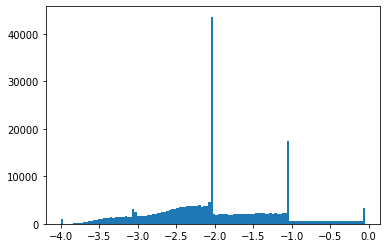

In [16]:
raw = out_runner_env.env_state.env_state.returned_episode_returns
clipped_data = np.clip(raw, -4, 0)
plt.hist(clipped_data, bins='auto')

In [17]:
len(out_runner_state)

4

In [18]:
type(out_runner_state[0])

flax.training.train_state.TrainState

In [19]:
out_runner_state[2].shape # env_state

(262144, 16)

In [20]:
out_runner_state[2][0]

Array([-0.3715996 , -0.53131104,  0.64987147, -0.68543893,  0.38545662,
       -0.36188373,  0.24497175,  0.73610026, -0.05186936, -0.6928743 ,
       -0.8875906 ,  0.7880059 ,  0.46457708,  0.9135377 ,  0.3944857 ,
       -1.2617759 ], dtype=float32)

In [21]:
return_rewards_mean = out["metrics"]["returned_episode_returns"].mean(-1).reshape(-1)

In [22]:
return_rewards_mean.shape

(1250,)

In [23]:
print('best batch reward',(return_rewards_mean[return_rewards_mean < 0]).max()) # best batch reward

best batch reward -2.0151389


In [24]:
out["metrics"]["returned_episode_returns"].shape

(125, 10, 262144)

In [25]:
return_rewards = out["metrics"]["returned_episode_returns"].reshape(-1)

In [26]:
return_rewards.shape
print('return_rewards.shape', return_rewards.shape)

return_rewards.shape (327680000,)


In [27]:
return_rewards

Array([ 0.       ,  0.       ,  0.       , ..., -2.3286235, -2.258132 ,
       -2.67865  ], dtype=float32)

In [28]:
print('absolute best reward per sample', (return_rewards[return_rewards < 0]).max()) # absolute best reward per sample

absolute best reward per sample -0.043977734


In [29]:
# Testing to see if FoM implementation is correct
# Also check how much FoM diverges when using less accurate output result from mlp model as opposed to golden SPICE sim result

from typing import Tuple, Optional
import chex
# Measure array (reference value from simulation)
Measure = jnp.array([
    1.738700e+08,  # ugf
    1.342800e+02,  # pm
    6.144200e-08,  # dc_gain
    9.234700e+01,  # cmrr
    6.605900e+01,  # psrr
    1.114900e+02,  # os
    1.798600e+00,  # upper_trig
    1.779000e-02,  # lower_trig
    5.159700e-04   # pwr
])
# Model output array (output from estimation model)
mlp_output = jnp.array([ 1.72730023e+08, -1.30592169e+01,  3.13270706e-08,  1.03272513e+02,
  6.93153630e+01,  1.19041006e+02,  1.76345655e+00,  8.49051201e-02,
  5.16918122e-04])

weights = jnp.array([1, 0, 1, 1, 1, 1, 1, 1, 1])
class EnvParams:
    x0_bounds: Tuple[float, float] = (100e-15, 10000e-15)
    x1_bounds: Tuple[float, float] = (180e-9, 2e-6)
    x2_bounds: Tuple[float, float] = (180e-9, 2e-6)
    x3_bounds: Tuple[float, float] = (180e-9, 2e-6)
    x4_bounds: Tuple[float, float] = (180e-9, 2e-6)
    x5_bounds: Tuple[float, float] = (180e-9, 2e-6)
    x6_bounds: Tuple[float, float] = (100e-15, 2000e-15)
    x7_bounds: Tuple[float, float] = (1, 20)
    x8_bounds: Tuple[float, float] = (1, 20)
    x9_bounds: Tuple[float, float] = (1, 20)
    x10_bounds: Tuple[float, float] = (220e-9, 150e-6)
    x11_bounds: Tuple[float, float] = (220e-9, 150e-6)
    x12_bounds: Tuple[float, float] = (220e-9, 150e-6)
    x13_bounds: Tuple[float, float] = (220e-9, 150e-6)
    x14_bounds: Tuple[float, float] = (220e-9, 150e-6)
    x15_bounds: Tuple[float, float] = (1e2, 1e5)
    out0_constraints: Tuple[float, int] = (30e6, 0)
    out1_constraints: Tuple[float, int] = (60, 0)
    out2_constraints: Tuple[float, int] = (100e-9, 1)
    out3_constraints: Tuple[float, int] = (80, 0)
    out4_constraints: Tuple[float, int] = (60, 0)
    out5_constraints: Tuple[float, int] = (80, 0)
    out6_constraints: Tuple[float, int] = (1.5, 0)
    out7_constraints: Tuple[float, int] = (30e-3, 1)
    out0_denormalize: Tuple[float, float] = (0.0, 645470000.0) # min, max, were mapped to [-1,1]
    out1_denormalize: Tuple[float, float] = (-180.0, 179.99)
    out2_denormalize: Tuple[float, float] = (1.2585e-11, 1e-06)
    out3_denormalize: Tuple[float, float] = (-68.19, 210.7)
    out4_denormalize: Tuple[float, float] = (-181.83, 99.497)
    out5_denormalize: Tuple[float, float] = (-4.0129, 150.14)
    out6_denormalize: Tuple[float, float] = (-1.3605, 1.8004)
    out7_denormalize: Tuple[float, float] = (8.661e-06, 2.882)
    out8_denormalize: Tuple[float, float] = (9.6713e-05, 0.0047157)
    num_states: int = 16
    num_spects: int = 9
    max_steps_in_episode: int = 20

# Takes in denormalized output to return FoM
def compute_reward(model_output: chex.Array, params: EnvParams, weights) -> float:
    # Uses FoM metric for reward
    # Denormalize the model output to compare against constraints
    # From [-1, 1] => [min, max]
    denormalize_params_min = jnp.array([
        params.out0_denormalize[0], params.out1_denormalize[0], params.out2_denormalize[0],
        params.out3_denormalize[0], params.out4_denormalize[0], params.out5_denormalize[0],
        params.out6_denormalize[0], params.out7_denormalize[0], params.out8_denormalize[0]
    ])
    denormalize_params_max = jnp.array([
        params.out0_denormalize[1], params.out1_denormalize[1], params.out2_denormalize[1],
        params.out3_denormalize[1], params.out4_denormalize[1], params.out5_denormalize[1],
        params.out6_denormalize[1], params.out7_denormalize[1], params.out8_denormalize[1]
    ])
    
    constraints = jnp.array([
        params.out0_constraints, params.out1_constraints, params.out2_constraints,
        params.out3_constraints, params.out4_constraints, params.out5_constraints,
        params.out6_constraints, params.out7_constraints
    ])

    model_output = ((2 * (model_output - denormalize_params_min)) / (denormalize_params_max - denormalize_params_min)) - 1
    out = denormalize_params_min + (((model_output + 1.0) * (denormalize_params_max - denormalize_params_min)) / 2.0)
    #out = model_output * jnp.sqrt(denormalize_params[:, 1]) + denormalize_params[:, 0]

    # Calculate scaled differences from constraints
    scaled_diffs = jnp.where(
        constraints[:, 1] == 1, 
        jnp.clip((out[:-1] - constraints[:, 0]) / constraints[:, 0], 0, 1),
        jnp.clip((constraints[:, 0] - out[:-1]) / constraints[:, 0], 0, 1)
    )
    # Append out[-1] to scaled_diffs
    scaled_diffs = jnp.append(scaled_diffs, out[-1])

    # Apply weights and sum
    weighted_diffs = weights * scaled_diffs
    FoM = jnp.sum(weighted_diffs)

    # Convert FoM to a reward
    reward = -1 * FoM

    return reward


def denormalize_input(model_output: chex.Array, params: EnvParams, weights) -> float:
    # Uses FoM metric for reward
    # Denormalize the model output to compare against constraints
    # From [-1, 1] => [min, max]
    denormalize_params_min = jnp.array([
        params.out0_denormalize[0], params.out1_denormalize[0], params.out2_denormalize[0],
        params.out3_denormalize[0], params.out4_denormalize[0], params.out5_denormalize[0],
        params.out6_denormalize[0], params.out7_denormalize[0], params.out8_denormalize[0]
    ])
    denormalize_params_max = jnp.array([
        params.out0_denormalize[1], params.out1_denormalize[1], params.out2_denormalize[1],
        params.out3_denormalize[1], params.out4_denormalize[1], params.out5_denormalize[1],
        params.out6_denormalize[1], params.out7_denormalize[1], params.out8_denormalize[1]
    ])
    
    constraints = jnp.array([
        params.out0_constraints, params.out1_constraints, params.out2_constraints,
        params.out3_constraints, params.out4_constraints, params.out5_constraints,
        params.out6_constraints, params.out7_constraints
    ])

    #model_output = ((2 * (model_output - denormalize_params_min)) / (denormalize_params_max - denormalize_params_min)) - 1
    out = denormalize_params_min + (((model_output + 1.0) * (denormalize_params_max - denormalize_params_min)) / 2.0)
    return out

def denormalize_input(norm_array, params):
    """
    Denormalize a normalized numpy array based on the bounds in EnvParams.
    
    :param norm_array: Normalized numpy array with values in the range [-1, 1].
    :param params: An instance of EnvParams containing the bounds for each element.
    :return: A numpy array with denormalized values.
    """
    bounds = np.array([
        params.x0_bounds, params.x1_bounds, params.x2_bounds, params.x3_bounds,
        params.x4_bounds, params.x5_bounds, params.x6_bounds, params.x7_bounds,
        params.x8_bounds, params.x9_bounds, params.x10_bounds, params.x11_bounds,
        params.x12_bounds, params.x13_bounds, params.x14_bounds, params.x15_bounds
    ])
    
    # Calculate the range (high - low) for each element
    ranges = bounds[:, 1] - bounds[:, 0]
    
    # Calculate the denormalized values
    denorm_array = (norm_array + 1) * ranges / 2 + bounds[:, 0]
    
    return denorm_array

reference_reward = compute_reward(Measure, EnvParams(), weights)

In [30]:
# Reference FoM implementation
import numpy as np

# Measure array
Measure = np.array([
    1.738700e+08,  # ugf
    1.342800e+02,  # pm
    6.144200e-08,  # dc_gain
    9.234700e+01,  # cmrr
    6.605900e+01,  # psrr
    1.114900e+02,  # os
    1.798600e+00,  # upper_trig
    1.779000e-02,  # lower_trig
    5.159700e-04   # pwr
])

# Weights for each measurement
weights = np.array([1, 0, 1, 1, 1, 1, 1, 1, 1])

# Constraints
constraints = np.array([
    [30e6, 0],      # ugf
    [60, 0],        # pm
    [100e-9, 1],    # dc_gain
    [80, 0],        # cmrr
    [60, 0],        # psrr
    [80, 0],        # os
    [1.5, 0],       # upper_trig
    [30e-3, 1]      # lower_trig
])

# Calculate FoM
accum = 0
len_constraints = len(constraints)
for i in range(len_constraints):
    if constraints[i][1] == 1:
        accum += weights[i] * min(1.0, max(0.0, (Measure[i] - constraints[i][0]) / constraints[i][0]))
    else:
        accum += weights[i] * min(1.0, max(0.0, (constraints[i][0] - Measure[i]) / constraints[i][0]))

FoM_out = accum + Measure[len_constraints]  # Adding the pwr value
FoM_out


0.00051597

In [31]:
reference_reward

Array(-0.00051597, dtype=float32)

In [32]:
mlp_model_reward = compute_reward(mlp_output, EnvParams(), weights)

In [33]:
mlp_model_reward

Array(-1.0005169, dtype=float32)

In [34]:
# denormalize best sample gate config
best_sample_gate_config = np.array(best_sample_gate_config)
best_sample_gate_config_denorm = denormalize_input(best_sample_gate_config, EnvParams())
print(best_sample_gate_config_denorm)

[2.81511690e-12 1.80000000e-07 1.40900500e-06 1.37580000e-06
 1.39883441e-06 1.80000000e-07 1.76215108e-12 2.00000000e+01
 1.08382437e+01 1.27930769e+01 2.20000000e-07 1.06903893e-04
 1.26783015e-04 6.49644662e-05 1.04823355e-04 8.87113976e+02]


In [35]:
for i in range(16):
    # Construct the attribute name
    attr_name = f"x{i}"
    value = best_sample_gate_config_denorm[i]
    print(f'{attr_name}: {value}')

x0: 2.815116903185844e-12
x1: 1.8e-07
x2: 1.4090049982070923e-06
x3: 1.3757999992370605e-06
x4: 1.3988344132900237e-06
x5: 1.8e-07
x6: 1.7621510803699492e-12
x7: 20.0
x8: 10.838243663311005
x9: 12.793076932430267
x10: 2.2e-07
x11: 0.00010690389308691024
x12: 0.00012678301512002944
x13: 6.49644662362337e-05
x14: 0.00010482335541725157
x15: 887.1139764785767
